# Vanilla GAN on MNIST dataset

In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.optim as optim
from torch.autograd.variable import Variable
from torch.nn import CrossEntropyLoss
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

#### loading MNIST data 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
to_image = transforms.ToPILImage()
trainset = datasets.MNIST(root="./mnist_data",train=True,download=True,transform=transform)
trainloader = DataLoader(trainset,batch_size=100,shuffle=True)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Define Class Discriminator and Generator
For discriminator we give an image(flattend) of size 784 and predict whether is it true/fake digit from MNIST. 
For Generator we give a radom noise of 100 dimensional data and predict a image(flattend) of size 784 to produce an digit inorder to fool discriminator.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.fc0 = Sequential(
                        nn.Linear(784,1024),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                    )
        self.fc1 = Sequential(
                    nn.Linear(1024,512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = Sequential(
                    nn.Linear(512,256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = Sequential(
                    nn.Linear(256,1),
                    nn.Sigmoid()
                    )
    def forward(self,x): # x is shape of 28X28 image tensor
        x = x.view(-1,784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.fc0 = Sequential(
                    nn.Linear(128,256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = Sequential(
                    nn.Linear(256,512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = Sequential(
                    nn.Linear(512,1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = Sequential(
                    nn.Linear(1024,784),
                    nn.Tanh()
                    )

    def forward(self,x): # x is noise of 100 dimensions
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1,1,28,28)
        return x

In [5]:
generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)
g_optim = optim.Adam(generator.parameters(),lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(),lr=2e-4)
criterion = nn.BCELoss()
g_losses=[]
d_losses=[]
images = []

def noise(n,n_features=128):
    return Variable(torch.randn(n,n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size,1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size,1))
    return data.to(device)

In [6]:
# discriminator must return sum of loss of real and fake data
def train_discriminator(optimizer,real_data,fake_data):
    n=real_data.size(0)
    optimizer.zero_grad()
    predicted_real = discriminator(real_data)
    real_loss = criterion(predicted_real,make_ones(n))
    real_loss.backward()
    
    
    predicted_fake = discriminator(fake_data)
    fake_loss = criterion(predicted_fake,make_zeros(n))
    fake_loss.backward()
    
    optimizer.step()
    
    return real_loss + fake_loss

def train_generator(optimizer,fake_data):
    n=fake_data.size(0)
    optimizer.zero_grad()
    predicted_fake = discriminator(fake_data)
    fake_loss = criterion(predicted_fake,make_ones(n))
    fake_loss.backward()
    optimizer.step()
    
    return fake_loss

In [7]:
epochs=100
test_noise = noise(64)
generator.train()
discriminator.train()
for epoch in range(epochs):
    g_error = 0.0
    d_error = 0.0
    for i,data in enumerate(trainloader):
        inputs,target = data
        real_data = inputs.to(device)
        n = inputs.size(0)
        fake_data = generator(noise(n)).detach()
        d_error += train_discriminator(d_optim,real_data,fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim,fake_data)
    
    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print("Epoch {}: g_loss is {:.6f} and d_loss is {:.6f} ".format(epoch,g_error/i,d_error/i))

print("Finished Training")
torch.save(generator.state_dict(),"mnist_generator.pt")

Epoch 0: g_loss is 3.423425 and d_loss is 0.862056 
Epoch 1: g_loss is 1.461986 and d_loss is 1.172712 
Epoch 2: g_loss is 1.808588 and d_loss is 0.888764 
Epoch 3: g_loss is 2.829979 and d_loss is 0.485380 
Epoch 4: g_loss is 2.825780 and d_loss is 0.551051 
Epoch 5: g_loss is 2.718867 and d_loss is 0.563408 
Epoch 6: g_loss is 2.510228 and d_loss is 0.593447 
Epoch 7: g_loss is 2.429132 and d_loss is 0.616431 
Epoch 8: g_loss is 2.516043 and d_loss is 0.608689 
Epoch 9: g_loss is 2.465598 and d_loss is 0.620850 
Epoch 10: g_loss is 2.241978 and d_loss is 0.689687 
Epoch 11: g_loss is 2.199371 and d_loss is 0.705307 
Epoch 12: g_loss is 2.021729 and d_loss is 0.754655 
Epoch 13: g_loss is 2.027311 and d_loss is 0.747990 
Epoch 14: g_loss is 1.906909 and d_loss is 0.819441 
Epoch 15: g_loss is 1.820309 and d_loss is 0.825160 
Epoch 16: g_loss is 1.795108 and d_loss is 0.843715 
Epoch 17: g_loss is 1.862570 and d_loss is 0.815230 
Epoch 18: g_loss is 1.730740 and d_loss is 0.866490 
Epo

In [8]:
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

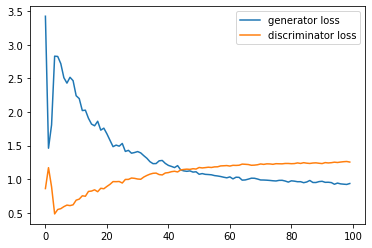

In [9]:
plt.plot(g_losses,label="generator loss")
plt.plot(d_losses,label="discriminator loss")
plt.legend()
plt.show()

In [10]:
!ls

data	    mnist_generator.pt	vangan.py
mnist_data  progress.gif	vanilla_gan.ipynb


In [11]:
!pwd

/home/ranjith.reddy/deep_learning/Generative-Models
